In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from model.nets import Siren
from model.flow import PipeFlow2D

In [2]:
Pn = [  complex(-0.5060,0.1245),
        complex(0.0802,0.0886),
        complex(0.0591,0.0251),
        complex(0.0228,0.0244),
        complex(0.0141,0.0071),
        complex(0.0112,0.0107),
        complex(0.0065,0.0056),
        complex(0.0067,0.0050),
        complex(0.0030,0.0040),
        complex(0.0044,0.0030),
        complex(0.0000,0.3710),
        complex(0.1493,0.0754),
        complex(0.0161,0.0103),
        complex(0.0166,0.0082),
        complex(-0.0002,0.0046),
        complex(0.0063,0.0001),
        complex(0.0008,0.0013),
        complex(0.0021,-0.0012),
        complex(0.0009,0.0015),
        complex(0.0001,-0.0001)]
pipe = PipeFlow2D(Po=-0.05,Pn=[complex(1,0.3),complex(-0.5,0.6),complex(0.1,0.1)],Wo=5)

In [3]:
Nx = 32
Nt = 32
x,y,t = np.meshgrid(np.linspace(0,8,4*Nx),np.linspace(-1,1,Nx),np.linspace(0,1,Nt))
u,v = pipe.velocity(x,y,t)
p = pipe.pressure(x,t)
X = np.concatenate((x.reshape((Nx**2*4*Nt,1)),y.reshape((Nx**2*4*Nt,1)),t.reshape((Nx**2*4*Nt,1))),axis=1)
U = np.concatenate((u.reshape((Nx**2*4*Nt,1)),v.reshape((Nx**2*4*Nt,1)),p.reshape((Nx**2*4*Nt,1))),axis=1)
X = torch.from_numpy(X).float().cuda()
U = torch.from_numpy(U).float().cuda()



In [4]:
xb = np.linspace(0,8,4*Nx)
yb = np.ones_like(xb)
xb = np.concatenate((xb,xb),axis=0)
yb = np.concatenate((yb,yb*-1),axis=0)
tb = np.zeros_like(xb)
ub = np.zeros_like(xb)
vb = np.zeros_like(xb)
dpdyb = np.zeros_like(xb)

Xb = np.concatenate((xb.reshape((8*Nx,1)),yb.reshape((8*Nx,1)),tb.reshape((8*Nx,1))),axis=1)
Ub = np.concatenate((ub.reshape((8*Nx,1)),vb.reshape((8*Nx,1))),axis=1)
Xb = torch.from_numpy(Xb).float().cuda()
Ub = torch.from_numpy(Ub).float().cuda()
dpdyb = torch.from_numpy(dpdyb).float().cuda()

In [5]:
net = Siren(in_features=3, out_features=3, hidden_features=256, 
                  hidden_layers=3, outermost_linear=True)
net.cuda()

Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=3, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): Linear(in_features=256, out_features=3, bias=True)
  )
)

In [6]:
total_steps = 5000

optim = torch.optim.Adam(lr=1e-4, params=net.parameters())

lam = 1

for step in range(total_steps):
    Up = net(X)
    
#     print('X:   ' + str(X.size()))
#     print('Xb:  ' + str(Xb.size()))
    
    Ubp = net(Xb)
    Ubp = Ubp[:,0:2]
    
#     print('Ub:  ' + str(Ub.size()))
#     print('Ubp: ' + str(Ubp.size()))
#     print('dpdybp: ' + str(dpdybp.size()))
    
    loss = ((U - Up)**2).mean() + lam*((Ub-Ubp)**2).mean()

    optim.zero_grad()
    loss.backward()
    optim.step()
    
    print("Loss " + str(step) + ": " + str(loss.item()))

Loss 0: 6.232933521270752
Loss 1: 6.182220935821533
Loss 2: 6.121777534484863
Loss 3: 6.042802333831787
Loss 4: 5.935992240905762
Loss 5: 5.802673816680908
Loss 6: 5.6565470695495605
Loss 7: 5.525057792663574
Loss 8: 5.4319868087768555
Loss 9: 5.367560386657715
Loss 10: 5.296213626861572
Loss 11: 5.208180904388428
Loss 12: 5.133167266845703
Loss 13: 5.088680267333984
Loss 14: 5.037625789642334
Loss 15: 4.980586051940918
Loss 16: 4.933814525604248
Loss 17: 4.886287212371826
Loss 18: 4.832958698272705
Loss 19: 4.783951759338379
Loss 20: 4.734572887420654
Loss 21: 4.679101943969727
Loss 22: 4.627195358276367
Loss 23: 4.576934814453125
Loss 24: 4.524027347564697
Loss 25: 4.473474025726318
Loss 26: 4.424983024597168
Loss 27: 4.374024391174316
Loss 28: 4.322734355926514
Loss 29: 4.272311210632324
Loss 30: 4.221919059753418
Loss 31: 4.172423839569092
Loss 32: 4.123507499694824
Loss 33: 4.074580669403076
Loss 34: 4.026716232299805
Loss 35: 3.9799575805664062
Loss 36: 3.9333086013793945
Loss 37

Loss 291: 0.5830007195472717
Loss 292: 0.5792216062545776
Loss 293: 0.5755904316902161
Loss 294: 0.5720850229263306
Loss 295: 0.5686830878257751
Loss 296: 0.5653584003448486
Loss 297: 0.5620957612991333
Loss 298: 0.5589104890823364
Loss 299: 0.5558716058731079
Loss 300: 0.5531847476959229
Loss 301: 0.5514015555381775
Loss 302: 0.5520181655883789
Loss 303: 0.5591795444488525
Loss 304: 0.5818648338317871
Loss 305: 0.6319589018821716
Loss 306: 0.6806665658950806
Loss 307: 0.6557446122169495
Loss 308: 0.5611082911491394
Loss 309: 0.5367985367774963
Loss 310: 0.5858365297317505
Loss 311: 0.633163332939148
Loss 312: 0.5721359252929688
Loss 313: 0.5234649777412415
Loss 314: 0.5682588815689087
Loss 315: 0.5755000114440918
Loss 316: 0.5170248746871948
Loss 317: 0.5415846109390259
Loss 318: 0.5407838225364685
Loss 319: 0.5057562589645386
Loss 320: 0.5294353365898132
Loss 321: 0.5123698711395264
Loss 322: 0.4994647800922394
Loss 323: 0.5134912729263306
Loss 324: 0.4910663664340973
Loss 325: 0.496

Loss 571: 0.14665772020816803
Loss 572: 0.14603912830352783
Loss 573: 0.14542384445667267
Loss 574: 0.144811749458313
Loss 575: 0.14420290291309357
Loss 576: 0.1435973197221756
Loss 577: 0.14299488067626953
Loss 578: 0.14239563047885895
Loss 579: 0.14179959893226624
Loss 580: 0.141206756234169
Loss 581: 0.14061716198921204
Loss 582: 0.1400308459997177
Loss 583: 0.13944806158542633
Loss 584: 0.13886912167072296
Loss 585: 0.1382949948310852
Loss 586: 0.13772745430469513
Loss 587: 0.13717059791088104
Loss 588: 0.1366337537765503
Loss 589: 0.13613811135292053
Loss 590: 0.13573460280895233
Loss 591: 0.13554291427135468
Loss 592: 0.13586415350437164
Loss 593: 0.1374031901359558
Loss 594: 0.1419474333524704
Loss 595: 0.15297971665859222
Loss 596: 0.17695006728172302
Loss 597: 0.21180717647075653
Loss 598: 0.23104700446128845
Loss 599: 0.18915793299674988
Loss 600: 0.13761349022388458
Loss 601: 0.15545836091041565
Loss 602: 0.17873415350914001
Loss 603: 0.14556512236595154
Loss 604: 0.13650272

Loss 845: 0.05380457639694214
Loss 846: 0.05362863093614578
Loss 847: 0.053453583270311356
Loss 848: 0.053279101848602295
Loss 849: 0.053105197846889496
Loss 850: 0.052932195365428925
Loss 851: 0.05276015028357506
Loss 852: 0.05258884280920029
Loss 853: 0.05241816118359566
Loss 854: 0.05224831774830818
Loss 855: 0.05207950621843338
Loss 856: 0.051911696791648865
Loss 857: 0.051744960248470306
Loss 858: 0.05157968029379845
Loss 859: 0.051416657865047455
Loss 860: 0.05125702545046806
Loss 861: 0.05110304430127144
Loss 862: 0.050959255546331406
Loss 863: 0.05083468556404114
Loss 864: 0.050747934728860855
Loss 865: 0.0507364347577095
Loss 866: 0.050880417227745056
Loss 867: 0.051343172788619995
Loss 868: 0.05248229578137398
Loss 869: 0.054978955537080765
Loss 870: 0.06022336333990097
Loss 871: 0.06994840502738953
Loss 872: 0.08540951460599899
Loss 873: 0.10019135475158691
Loss 874: 0.09858138859272003
Loss 875: 0.07166272401809692
Loss 876: 0.0509575679898262
Loss 877: 0.062112558633089066

Loss 1112: 0.025024263188242912
Loss 1113: 0.024951888248324394
Loss 1114: 0.024883903563022614
Loss 1115: 0.024817541241645813
Loss 1116: 0.024750009179115295
Loss 1117: 0.024680985137820244
Loss 1118: 0.024614648893475533
Loss 1119: 0.024549098685383797
Loss 1120: 0.024481523782014847
Loss 1121: 0.024415450170636177
Loss 1122: 0.024349452927708626
Loss 1123: 0.024284888058900833
Loss 1124: 0.024218780919909477
Loss 1125: 0.02415313385426998
Loss 1126: 0.02408944070339203
Loss 1127: 0.024024683982133865
Loss 1128: 0.02395995520055294
Loss 1129: 0.023895949125289917
Loss 1130: 0.023832593113183975
Loss 1131: 0.023768913000822067
Loss 1132: 0.023705456405878067
Loss 1133: 0.02364233322441578
Loss 1134: 0.023579681292176247
Loss 1135: 0.023517347872257233
Loss 1136: 0.02345452830195427
Loss 1137: 0.023392528295516968
Loss 1138: 0.023330895230174065
Loss 1139: 0.023269087076187134
Loss 1140: 0.023207617923617363
Loss 1141: 0.023146364837884903
Loss 1142: 0.02308546006679535
Loss 1143: 0.0

Loss 1373: 0.013315845280885696
Loss 1374: 0.013285021297633648
Loss 1375: 0.013254229910671711
Loss 1376: 0.013223706744611263
Loss 1377: 0.013193128630518913
Loss 1378: 0.0131627656519413
Loss 1379: 0.013132394291460514
Loss 1380: 0.013102138414978981
Loss 1381: 0.013072055764496326
Loss 1382: 0.013041933998465538
Loss 1383: 0.013012056238949299
Loss 1384: 0.012982216663658619
Loss 1385: 0.012952390126883984
Loss 1386: 0.012922778725624084
Loss 1387: 0.012893169187009335
Loss 1388: 0.01286366954445839
Loss 1389: 0.012834287248551846
Loss 1390: 0.012804968282580376
Loss 1391: 0.012775764800608158
Loss 1392: 0.012746625579893589
Loss 1393: 0.012717586942017078
Loss 1394: 0.01268862560391426
Loss 1395: 0.012659735977649689
Loss 1396: 0.012630968354642391
Loss 1397: 0.012602267786860466
Loss 1398: 0.012573647312819958
Loss 1399: 0.01254513580352068
Loss 1400: 0.012516683898866177
Loss 1401: 0.01248832419514656
Loss 1402: 0.012460056692361832
Loss 1403: 0.01243184320628643
Loss 1404: 0.01

Loss 1633: 0.007709494326263666
Loss 1634: 0.007693799212574959
Loss 1635: 0.00767815625295043
Loss 1636: 0.007662549614906311
Loss 1637: 0.007647000718861818
Loss 1638: 0.007631507236510515
Loss 1639: 0.007616071961820126
Loss 1640: 0.007600728422403336
Loss 1641: 0.0075854952447116375
Loss 1642: 0.007570451591163874
Loss 1643: 0.007555696647614241
Loss 1644: 0.007541435305029154
Loss 1645: 0.0075280675664544106
Loss 1646: 0.007516327779740095
Loss 1647: 0.007507640868425369
Loss 1648: 0.007504794280976057
Loss 1649: 0.007513187825679779
Loss 1650: 0.007543763145804405
Loss 1651: 0.007617961149662733
Loss 1652: 0.007780305575579405
Loss 1653: 0.008117425255477428
Loss 1654: 0.008812174201011658
Loss 1655: 0.010195687413215637
Loss 1656: 0.012941773049533367
Loss 1657: 0.017881201580166817
Loss 1658: 0.0262007974088192
Loss 1659: 0.03560365363955498
Loss 1660: 0.041711509227752686
Loss 1661: 0.03292571008205414
Loss 1662: 0.01535235345363617
Loss 1663: 0.008534207008779049
Loss 1664: 0

Loss 1893: 0.0057149301283061504
Loss 1894: 0.005311456508934498
Loss 1895: 0.005392149556428194
Loss 1896: 0.0055852411314845085
Loss 1897: 0.005141683388501406
Loss 1898: 0.005149823613464832
Loss 1899: 0.005442257039248943
Loss 1900: 0.00503835454583168
Loss 1901: 0.00497725885361433
Loss 1902: 0.005273330025374889
Loss 1903: 0.004980605095624924
Loss 1904: 0.00487460196018219
Loss 1905: 0.005094275809824467
Loss 1906: 0.004930767230689526
Loss 1907: 0.004823153372853994
Loss 1908: 0.004933561198413372
Loss 1909: 0.004873758647590876
Loss 1910: 0.004799124784767628
Loss 1911: 0.004810978192836046
Loss 1912: 0.0048010218888521194
Loss 1913: 0.004779573064297438
Loss 1914: 0.004732905887067318
Loss 1915: 0.004725208971649408
Loss 1916: 0.004747272469103336
Loss 1917: 0.0046890415251255035
Loss 1918: 0.004658580757677555
Loss 1919: 0.004697576630860567
Loss 1920: 0.004661861807107925
Loss 1921: 0.004613651894032955
Loss 1922: 0.004638025537133217
Loss 1923: 0.004630475305020809
Loss 19

Loss 2149: 0.0031437950674444437
Loss 2150: 0.0031374453101307154
Loss 2151: 0.003131951205432415
Loss 2152: 0.003125943709164858
Loss 2153: 0.003120162757113576
Loss 2154: 0.0031146546825766563
Loss 2155: 0.0031086707022041082
Loss 2156: 0.003103206166997552
Loss 2157: 0.0030974517576396465
Loss 2158: 0.0030917853582650423
Loss 2159: 0.0030862598214298487
Loss 2160: 0.0030805349815636873
Loss 2161: 0.003075087210163474
Loss 2162: 0.003069500671699643
Loss 2163: 0.0030639690812677145
Loss 2164: 0.003058538306504488
Loss 2165: 0.003053017659112811
Loss 2166: 0.003047586651518941
Loss 2167: 0.003042155411094427
Loss 2168: 0.0030367106664925814
Loss 2169: 0.0030313527677208185
Loss 2170: 0.0030259478371590376
Loss 2171: 0.003020588541403413
Loss 2172: 0.0030152720864862204
Loss 2173: 0.0030099297873675823
Loss 2174: 0.003004642901942134
Loss 2175: 0.002999355550855398
Loss 2176: 0.0029940870590507984
Loss 2177: 0.002988846506923437
Loss 2178: 0.0029836073517799377
Loss 2179: 0.00297838775

Loss 2403: 0.0021056048572063446
Loss 2404: 0.002102273516356945
Loss 2405: 0.002098949160426855
Loss 2406: 0.0020956317894160748
Loss 2407: 0.002092326059937477
Loss 2408: 0.0020890238229185343
Loss 2409: 0.0020857290364801884
Loss 2410: 0.0020824428647756577
Loss 2411: 0.002079167403280735
Loss 2412: 0.0020758972968906164
Loss 2413: 0.002072637900710106
Loss 2414: 0.0020693920087069273
Loss 2415: 0.002066156594082713
Loss 2416: 0.0020629395730793476
Loss 2417: 0.0020597469992935658
Loss 2418: 0.0020565963350236416
Loss 2419: 0.0020535006187856197
Loss 2420: 0.0020505008287727833
Loss 2421: 0.0020476658828556538
Loss 2422: 0.0020451094023883343
Loss 2423: 0.002043045125901699
Loss 2424: 0.002041866770014167
Loss 2425: 0.002042294479906559
Loss 2426: 0.002045667264610529
Loss 2427: 0.0020545274019241333
Loss 2428: 0.0020736753940582275
Loss 2429: 0.0021124144550412893
Loss 2430: 0.0021884860470891
Loss 2431: 0.0023368881084024906
Loss 2432: 0.0026240930892527103
Loss 2433: 0.0031813154

Loss 2655: 0.0018319371156394482
Loss 2656: 0.0021769427694380283
Loss 2657: 0.003077203407883644
Loss 2658: 0.002687797648832202
Loss 2659: 0.001779960817657411
Loss 2660: 0.0018278196221217513
Loss 2661: 0.002374048111960292
Loss 2662: 0.0023112865164875984
Loss 2663: 0.0018291166052222252
Loss 2664: 0.0017356083262711763
Loss 2665: 0.0019542148802429438
Loss 2666: 0.001989818876609206
Loss 2667: 0.0018100303132086992
Loss 2668: 0.0016977445920929313
Loss 2669: 0.0017421060474589467
Loss 2670: 0.0017636234406381845
Loss 2671: 0.0017171078361570835
Loss 2672: 0.0016964233946055174
Loss 2673: 0.0016635191859677434
Loss 2674: 0.0015948847867548466
Loss 2675: 0.0016111268196254969
Loss 2676: 0.0016784417675808072
Loss 2677: 0.0016273430082947016
Loss 2678: 0.0015190483536571264
Loss 2679: 0.0015336290234699845
Loss 2680: 0.0016108941053971648
Loss 2681: 0.0015910251531749964
Loss 2682: 0.0015108983498066664
Loss 2683: 0.0014943948481231928
Loss 2684: 0.001531972666271031
Loss 2685: 0.001

Loss 2909: 0.0010903305374085903
Loss 2910: 0.0010887907119467854
Loss 2911: 0.0010872178245335817
Loss 2912: 0.0010857688030228019
Loss 2913: 0.0010844941716641188
Loss 2914: 0.0010833634296432137
Loss 2915: 0.0010824580676853657
Loss 2916: 0.001081999740563333
Loss 2917: 0.001082210335880518
Loss 2918: 0.0010833833366632462
Loss 2919: 0.0010860668262466788
Loss 2920: 0.0010912955040112138
Loss 2921: 0.0011005217675119638
Loss 2922: 0.001116327941417694
Loss 2923: 0.0011425602715462446
Loss 2924: 0.0011866097338497639
Loss 2925: 0.001258514472283423
Loss 2926: 0.001378488028421998
Loss 2927: 0.0015704341931268573
Loss 2928: 0.0018847031751647592
Loss 2929: 0.002358020283281803
Loss 2930: 0.0030716804321855307
Loss 2931: 0.003959353081882
Loss 2932: 0.004931236617267132
Loss 2933: 0.00542948953807354
Loss 2934: 0.004964433144778013
Loss 2935: 0.0034153982996940613
Loss 2936: 0.0017208404606208205
Loss 2937: 0.001221387297846377
Loss 2938: 0.001937011955305934
Loss 2939: 0.0025740640703

Loss 3160: 0.0010507203405722976
Loss 3161: 0.0013359012082219124
Loss 3162: 0.0016110241413116455
Loss 3163: 0.0015339148230850697
Loss 3164: 0.0012850466882809997
Loss 3165: 0.0012520087184384465
Loss 3166: 0.0013642190024256706
Loss 3167: 0.0013433318817988038
Loss 3168: 0.0012085371417924762
Loss 3169: 0.0011652301764115691
Loss 3170: 0.0012194163864478469
Loss 3171: 0.0011851676972582936
Loss 3172: 0.0010188496671617031
Loss 3173: 0.0008683055057190359
Loss 3174: 0.0008610758231952786
Loss 3175: 0.0009233429445885122
Loss 3176: 0.0009333478519693017
Loss 3177: 0.0009011880028992891
Loss 3178: 0.0009005710016936064
Loss 3179: 0.0009365618461742997
Loss 3180: 0.0009480310836806893
Loss 3181: 0.0009146099328063428
Loss 3182: 0.0008830378064885736
Loss 3183: 0.0008864488918334246
Loss 3184: 0.0008991322247311473
Loss 3185: 0.0008795579196885228
Loss 3186: 0.0008348200935870409
Loss 3187: 0.0008037678198888898
Loss 3188: 0.0008040909306146204
Loss 3189: 0.0008157275151461363
Loss 3190:

Loss 3412: 0.0006292751058936119
Loss 3413: 0.0006281712558120489
Loss 3414: 0.0006272201426327229
Loss 3415: 0.0006262591341510415
Loss 3416: 0.0006252095918171108
Loss 3417: 0.0006242369418032467
Loss 3418: 0.000623287633061409
Loss 3419: 0.000622254447080195
Loss 3420: 0.0006212552543729544
Loss 3421: 0.00062031508423388
Loss 3422: 0.0006193388253450394
Loss 3423: 0.0006183650111779571
Loss 3424: 0.0006174255395308137
Loss 3425: 0.0006164709920994937
Loss 3426: 0.0006155167357064784
Loss 3427: 0.0006145911174826324
Loss 3428: 0.0006136593874543905
Loss 3429: 0.0006127273081801832
Loss 3430: 0.0006118228775449097
Loss 3431: 0.0006109203677624464
Loss 3432: 0.0006100045866332948
Loss 3433: 0.0006091079558245838
Loss 3434: 0.0006082394393160939
Loss 3435: 0.0006073750555515289
Loss 3436: 0.0006065269699320197
Loss 3437: 0.0006057292921468616
Loss 3438: 0.0006049799849279225
Loss 3439: 0.000604278699029237
Loss 3440: 0.0006036576814949512
Loss 3441: 0.0006031203083693981
Loss 3442: 0.00

Loss 3661: 0.000500112830195576
Loss 3662: 0.0005057161906734109
Loss 3663: 0.000513874867465347
Loss 3664: 0.00052531564142555
Loss 3665: 0.0005417365464381874
Loss 3666: 0.0005660917959176004
Loss 3667: 0.0006029900396242738
Loss 3668: 0.0006578734028153121
Loss 3669: 0.0007402728660963476
Loss 3670: 0.0008588311029598117
Loss 3671: 0.0010337852872908115
Loss 3672: 0.0012712343595921993
Loss 3673: 0.0016005930956453085
Loss 3674: 0.001978527754545212
Loss 3675: 0.0024028397165238857
Loss 3676: 0.002660233760252595
Loss 3677: 0.002689882880076766
Loss 3678: 0.0022258860990405083
Loss 3679: 0.0015076766721904278
Loss 3680: 0.0008117635152302682
Loss 3681: 0.000562673551030457
Loss 3682: 0.0007782270549796522
Loss 3683: 0.001101558213122189
Loss 3684: 0.0011550267226994038
Loss 3685: 0.0008862456888891757
Loss 3686: 0.0006065573543310165
Loss 3687: 0.0005815245676785707
Loss 3688: 0.0007562263635918498
Loss 3689: 0.0008605297189205885
Loss 3690: 0.000754489388782531
Loss 3691: 0.0005680

Loss 3913: 0.00041746837086975574
Loss 3914: 0.0004197474627289921
Loss 3915: 0.0004156551731284708
Loss 3916: 0.000414768437622115
Loss 3917: 0.00041430623969063163
Loss 3918: 0.0004109181754756719
Loss 3919: 0.000411426299251616
Loss 3920: 0.0004092033195775002
Loss 3921: 0.00040772309876047075
Loss 3922: 0.0004079708887729794
Loss 3923: 0.00040543111390434206
Loss 3924: 0.0004054320161230862
Loss 3925: 0.00040485983481630683
Loss 3926: 0.00040277306106872857
Loss 3927: 0.00040276721119880676
Loss 3928: 0.00040149156120605767
Loss 3929: 0.0004003263311460614
Loss 3930: 0.0003999062755610794
Loss 3931: 0.00039840411045588553
Loss 3932: 0.00039785951958037913
Loss 3933: 0.00039710846613161266
Loss 3934: 0.00039589888183400035
Loss 3935: 0.0003956040018238127
Loss 3936: 0.0003946104843635112
Loss 3937: 0.0003936744178645313
Loss 3938: 0.0003932475810870528
Loss 3939: 0.00039224536158144474
Loss 3940: 0.00039153487887233496
Loss 3941: 0.00039087599725462496
Loss 3942: 0.00038995617069303

Loss 4160: 0.0004127115826122463
Loss 4161: 0.000527699594385922
Loss 4162: 0.000507630524225533
Loss 4163: 0.0003911002422682941
Loss 4164: 0.0003986140072811395
Loss 4165: 0.000456884823506698
Loss 4166: 0.0004121405363548547
Loss 4167: 0.00036051584174856544
Loss 4168: 0.00039727380499243736
Loss 4169: 0.0004176099901087582
Loss 4170: 0.00037507773959077895
Loss 4171: 0.00036049989284947515
Loss 4172: 0.00038287011557258666
Loss 4173: 0.0003697203646879643
Loss 4174: 0.00034015579149127007
Loss 4175: 0.000352156232111156
Loss 4176: 0.00037197174970060587
Loss 4177: 0.00035495878546498716
Loss 4178: 0.00033589970553293824
Loss 4179: 0.00034442494506947696
Loss 4180: 0.00034931188565678895
Loss 4181: 0.00033562921453267336
Loss 4182: 0.0003305523714516312
Loss 4183: 0.0003389119228813797
Loss 4184: 0.0003378824330866337
Loss 4185: 0.0003287796280346811
Loss 4186: 0.00032945245038717985
Loss 4187: 0.0003343316202517599
Loss 4188: 0.0003294238995295018
Loss 4189: 0.0003221222141291946
L

Loss 4407: 0.0003321071853861213
Loss 4408: 0.0003406906616874039
Loss 4409: 0.0003152629069518298
Loss 4410: 0.0002928330795839429
Loss 4411: 0.00030055499519221485
Loss 4412: 0.00031290907645598054
Loss 4413: 0.000306079862639308
Loss 4414: 0.0002932183269876987
Loss 4415: 0.0002925391017924994
Loss 4416: 0.0002948635374195874
Loss 4417: 0.00028688693419098854
Loss 4418: 0.00027691959985531867
Loss 4419: 0.000277558749075979
Loss 4420: 0.00028330332133919
Loss 4421: 0.00028175002080388367
Loss 4422: 0.0002750839339569211
Loss 4423: 0.0002731874992605299
Loss 4424: 0.0002749885607045144
Loss 4425: 0.0002724665682762861
Loss 4426: 0.000266724411631003
Loss 4427: 0.0002651674731168896
Loss 4428: 0.0002680303587112576
Loss 4429: 0.00026869672001339495
Loss 4430: 0.00026543380226939917
Loss 4431: 0.0002631400420796126
Loss 4432: 0.0002638910664245486
Loss 4433: 0.00026397567125968635
Loss 4434: 0.00026128135505132377
Loss 4435: 0.00025873398408293724
Loss 4436: 0.00025880493922159076
Loss

Loss 4657: 0.00023299174790736288
Loss 4658: 0.00023280146706383675
Loss 4659: 0.00023248340585269034
Loss 4660: 0.00023199620773084462
Loss 4661: 0.0002314271841896698
Loss 4662: 0.00023091021284926683
Loss 4663: 0.00023052081814967096
Loss 4664: 0.00023023199173621833
Loss 4665: 0.00022995448671281338
Loss 4666: 0.00022960995556786656
Loss 4667: 0.00022918425383977592
Loss 4668: 0.00022872499539516866
Loss 4669: 0.00022829549561720341
Loss 4670: 0.00022792913659941405
Loss 4671: 0.00022761060972698033
Loss 4672: 0.00022729634656570852
Loss 4673: 0.0002269499091198668
Loss 4674: 0.0002265658840769902
Loss 4675: 0.00022616630303673446
Loss 4676: 0.000225781011977233
Loss 4677: 0.00022542611986864358
Loss 4678: 0.00022509563132189214
Loss 4679: 0.00022477000311482698
Loss 4680: 0.00022443223861046135
Loss 4681: 0.00022407699725590646
Loss 4682: 0.00022371267550624907
Loss 4683: 0.0002233529376098886
Loss 4684: 0.00022300683485809714
Loss 4685: 0.00022267438180278987
Loss 4686: 0.0002223

Loss 4902: 0.00068061170168221
Loss 4903: 0.0009649686980992556
Loss 4904: 0.0023444846738129854
Loss 4905: 0.0020029328297823668
Loss 4906: 0.0007558913202956319
Loss 4907: 0.0009296379867009819
Loss 4908: 0.0014970526099205017
Loss 4909: 0.0009983510244637728
Loss 4910: 0.0006826561875641346
Loss 4911: 0.001202851883135736
Loss 4912: 0.0012040868168696761
Loss 4913: 0.0009549784008413553
Loss 4914: 0.001615213928744197
Loss 4915: 0.002368886023759842
Loss 4916: 0.0028464472852647305
Loss 4917: 0.0034744441509246826
Loss 4918: 0.004312827717512846
Loss 4919: 0.003366470569744706
Loss 4920: 0.0020166640169918537
Loss 4921: 0.0011893912451341748
Loss 4922: 0.001142912544310093
Loss 4923: 0.0011913110502064228
Loss 4924: 0.0012963591143488884
Loss 4925: 0.0014139721170067787
Loss 4926: 0.001092013088054955
Loss 4927: 0.0005737518658861518
Loss 4928: 0.0006844282033853233
Loss 4929: 0.0011187971103936434
Loss 4930: 0.0010125954868271947
Loss 4931: 0.0005500526749528944
Loss 4932: 0.000399

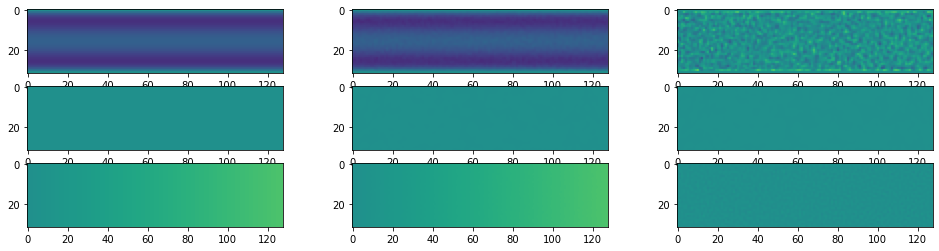

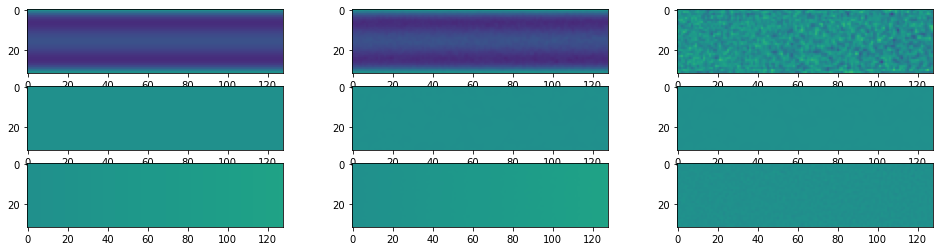

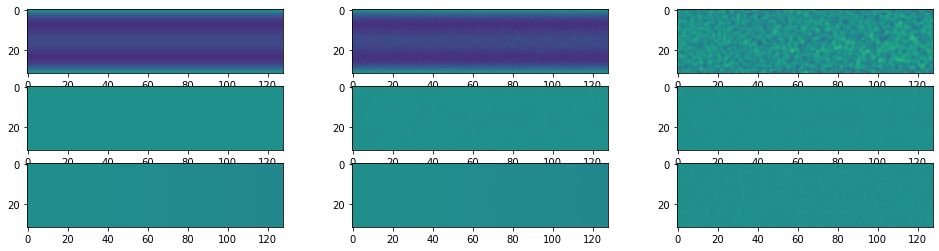

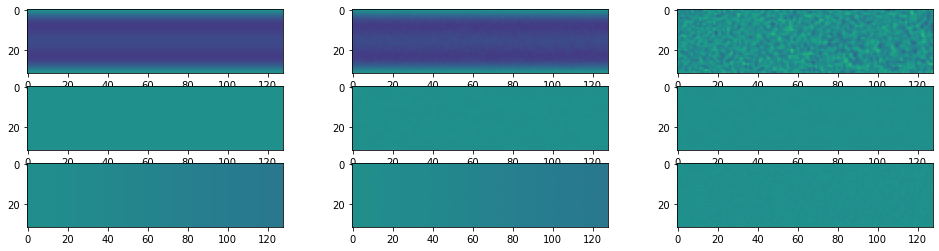

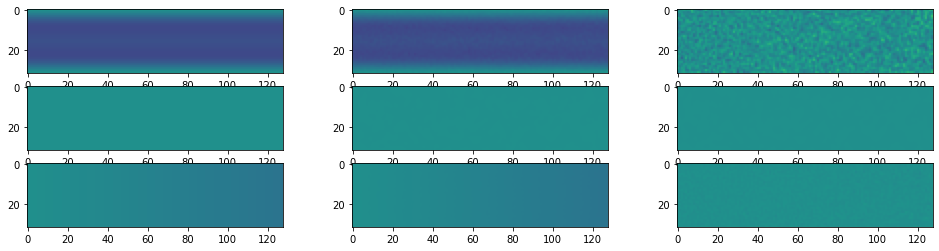

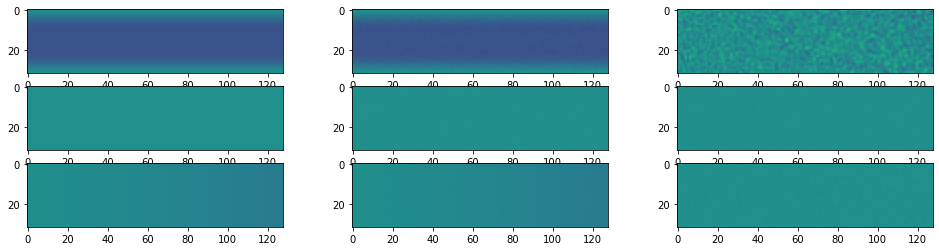

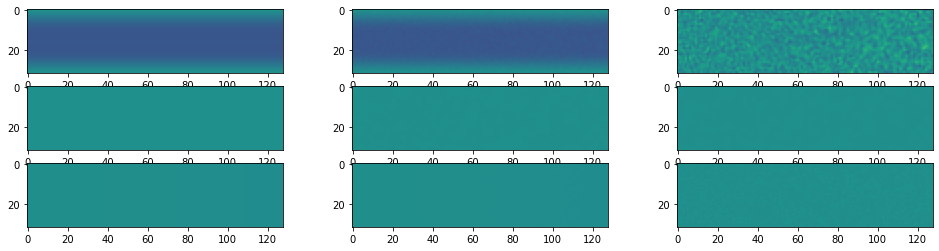

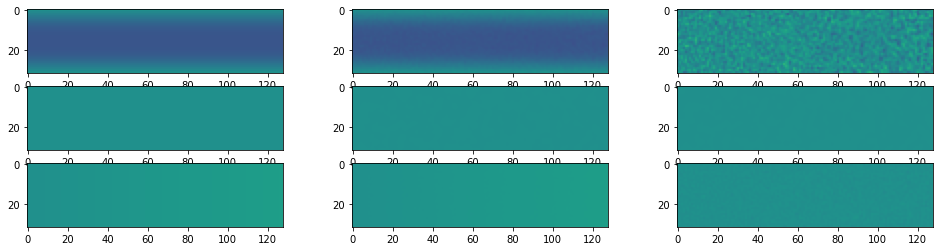

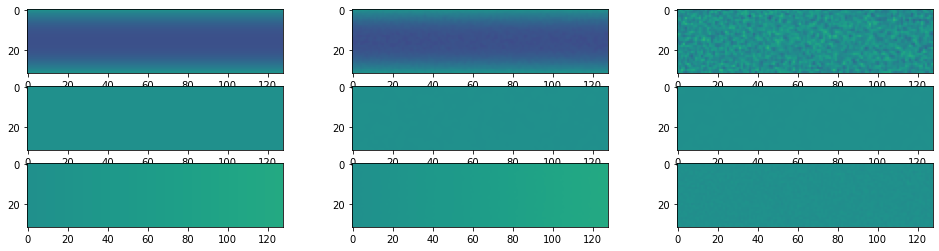

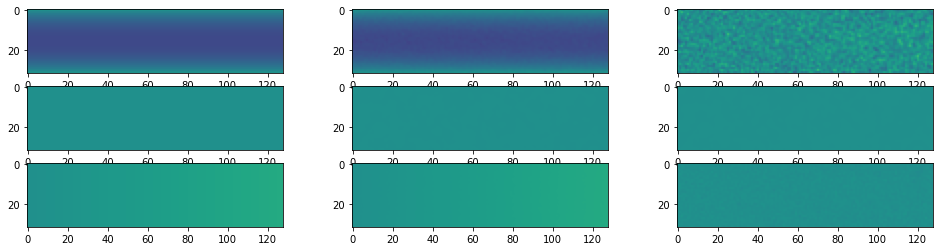

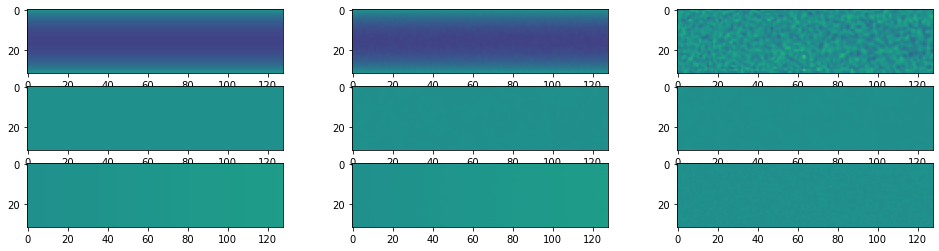

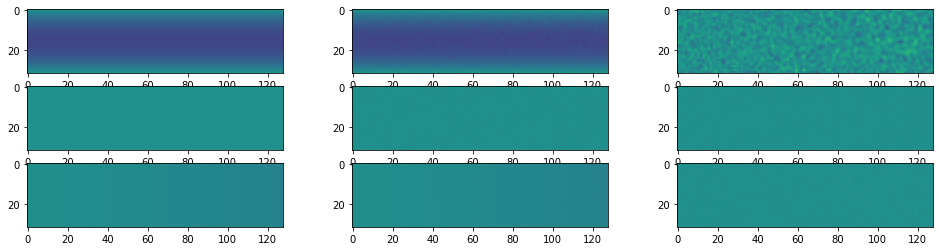

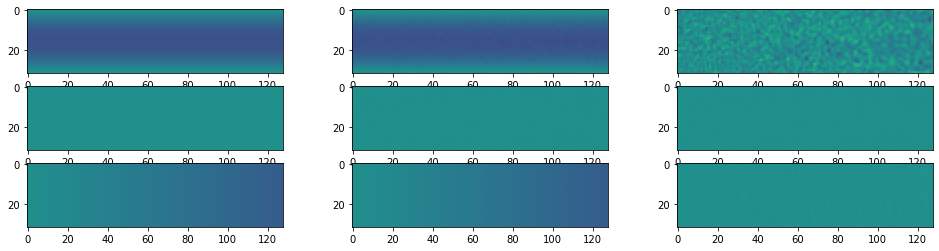

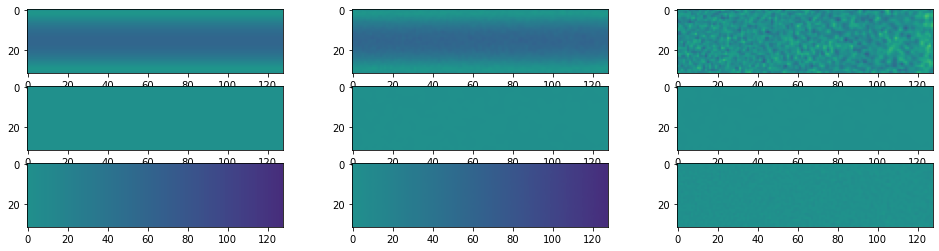

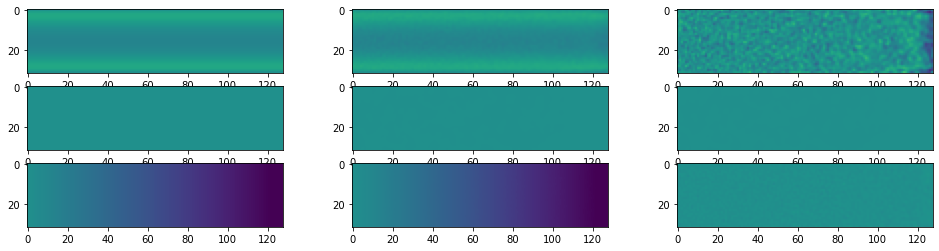

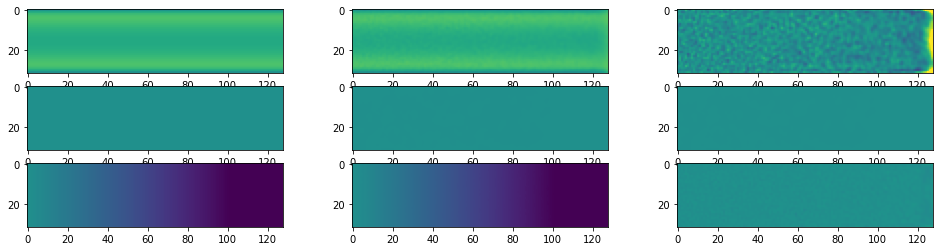

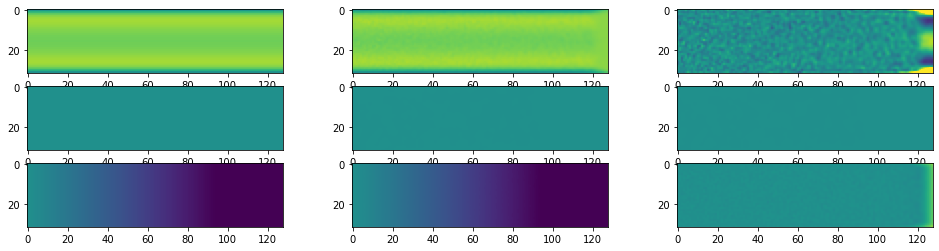

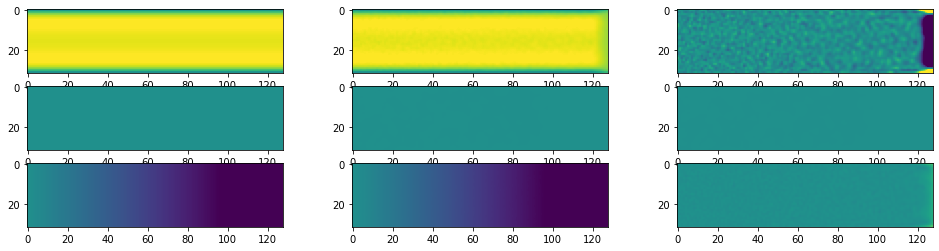

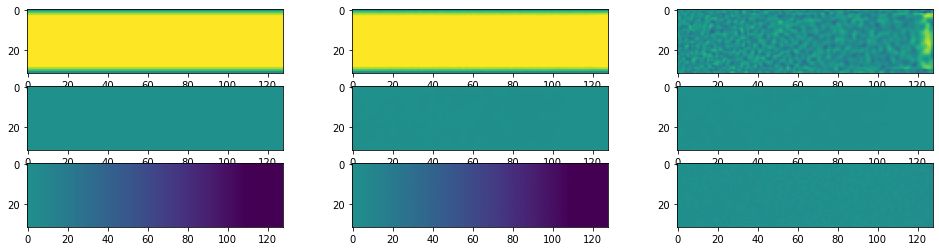

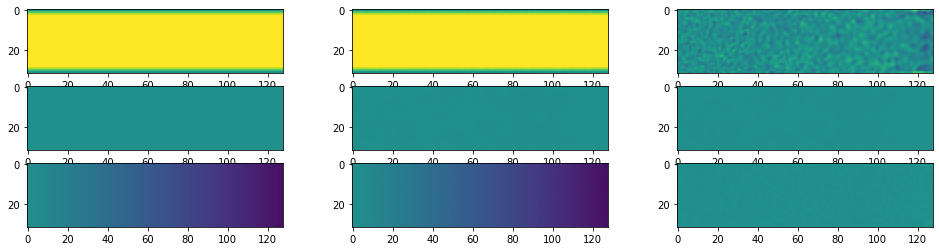

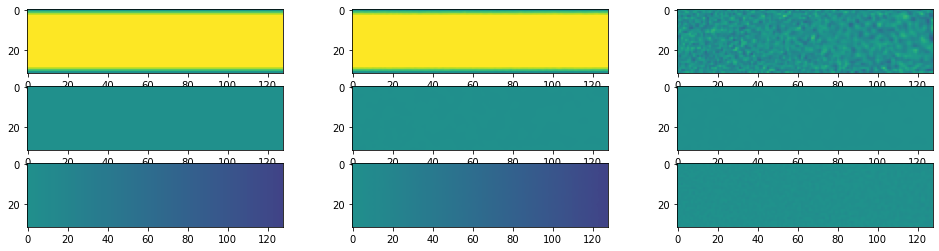

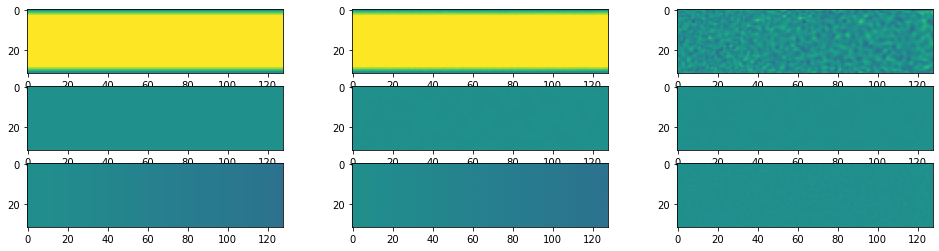

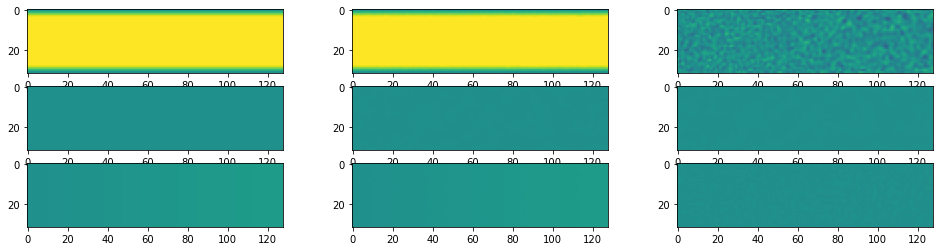

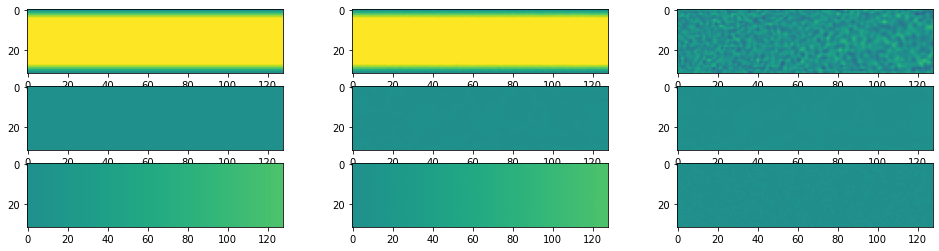

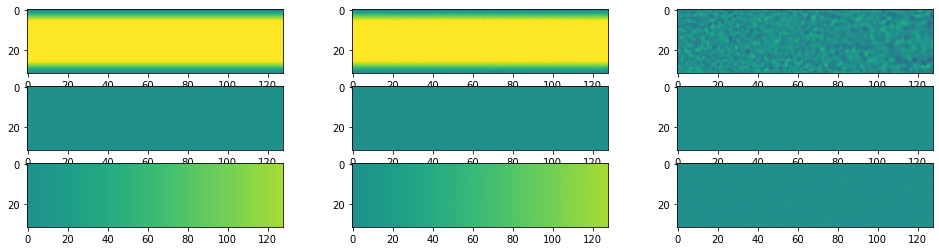

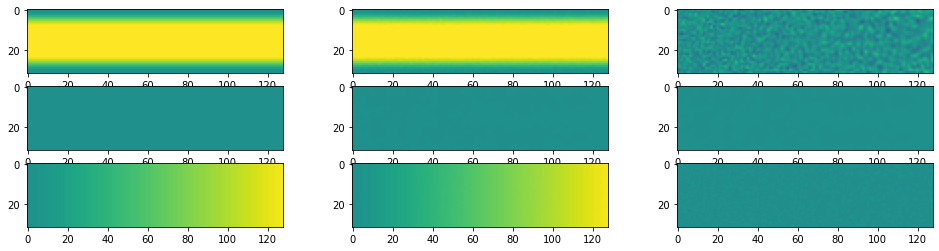

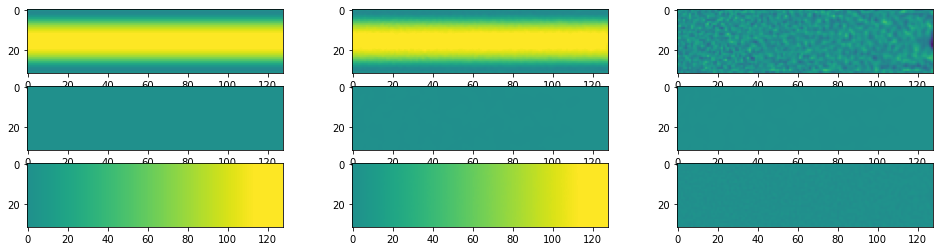

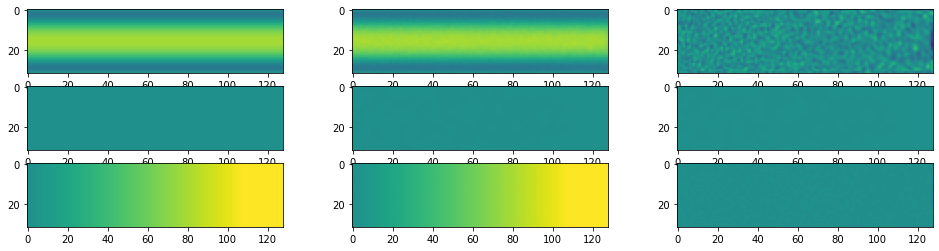

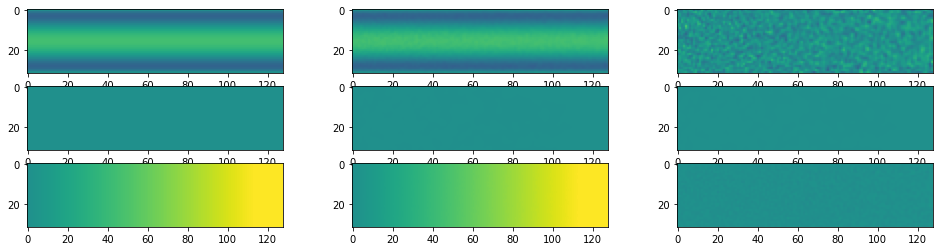

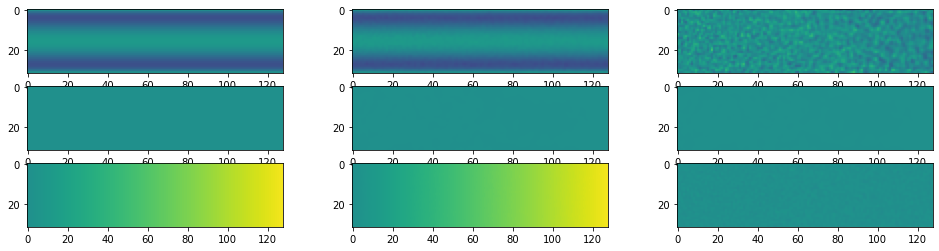

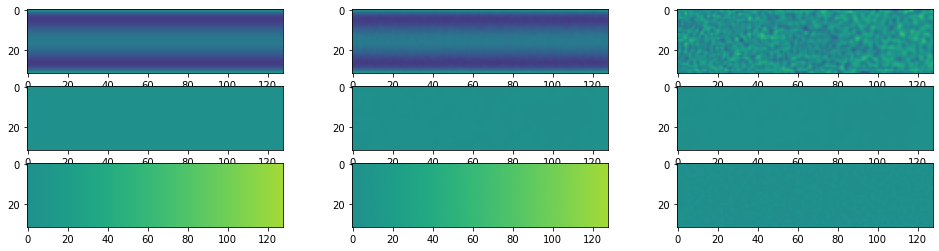

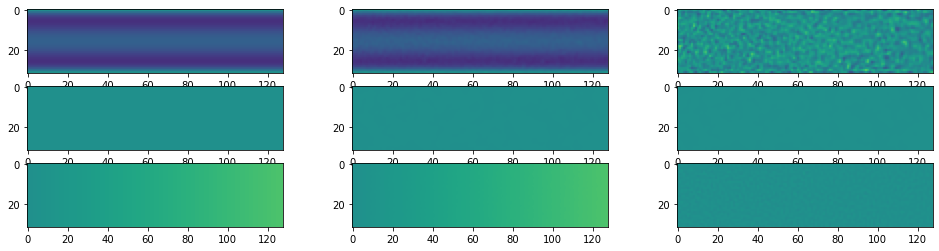

In [7]:
Nxt = 32
Ntt = Nt
xt,yt,tt = np.meshgrid(np.linspace(0,8,4*Nxt),np.linspace(-1,1,Nxt),np.linspace(0,1,Ntt))
ut,vt = pipe.velocity(xt,yt,tt)
pt = pipe.pressure(xt,tt)
Xt = np.concatenate((xt.reshape((Nxt**2*4*Ntt,1)),yt.reshape((Nxt**2*4*Ntt,1)),tt.reshape((Nxt**2*4*Ntt,1))),axis=1)
Xt = torch.from_numpy(Xt).float().cuda()
Upt = net(Xt)

Upt = Upt.cpu().detach().numpy().reshape((Nxt,4*Nxt,Ntt,3))
upt = Upt[:,:,:,0]
vpt = Upt[:,:,:,1]
ppt = Upt[:,:,:,2]
for tn in np.arange(Nt):
    fig, axes = plt.subplots(3,3, figsize=(16.5,4.0))
    axes[0,0].imshow(ut[:,:,tn],vmin=-1,vmax=1)
    axes[0,1].imshow(upt[:,:,tn],vmin=-1,vmax=1)
    axes[0,2].imshow(upt[:,:,tn]-ut[:,:,tn],vmin=-0.1,vmax=0.1)
    axes[1,0].imshow(vt[:,:,tn],vmin=-1,vmax=1)
    axes[1,1].imshow(vpt[:,:,tn],vmin=-1,vmax=1)
    axes[1,2].imshow(vpt[:,:,tn]-vt[:,:,tn],vmin=-0.1,vmax=0.1)
    axes[2,0].imshow(pt[:,:,tn],vmin=-10,vmax=10)
    axes[2,1].imshow(ppt[:,:,tn],vmin=-10,vmax=10)
    axes[2,2].imshow(ppt[:,:,tn]-pt[:,:,tn],vmin=-1,vmax=1)
    
    plt.show()